In [69]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.tri as tri
import os

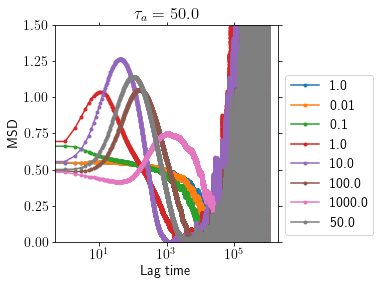

In [159]:
mpl.rcParams.update({'font.size':14, 'text.usetex':True})
fig,ax=plt.subplots(1,1,figsize=(4,4),gridspec_kw={'wspace':0.4, 'hspace':0.4})
ind=4
fpath='../../data/SAC_exp/'
for (name,tp) in [('low',1)]:#,('mid',1.0), ('high',2.)]:
    Ts,Fs,Tas=[],[],[]
    Rmax=[]
    betas=[]

    ax.clear()
    colors = pl.cm.hot(np.linspace(0,1,12))
    count=0
    for fname in os.listdir(fpath+'MSD/'):
        if '.npy' in fname and 'MSD' in fname:# and 'rep2' in fname:
            # print(fname.split('_'))
            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            blsize=float(fname.split('_')[ind+6].replace('blocksize',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            # print(T,F,Ta,Esoft,R0)
            tblck=dt*blsize
            
            npyfile=np.load(fpath+'MSD/'+fname)
            t0,=npyfile.shape
            ts=np.arange(0,npyfile.shape[0]*tblck,tblck)

            Tas.append(Ta)
            Fs.append(F)
            slope=np.gradient(np.log(npyfile[1:-10000]))/np.gradient(np.log(ts[1:-10000]))
            slope_non_zero=np.array([xx for xx in slope if 3>xx>1e-4])
            Rmax.append(np.max(slope_non_zero))
            # print(np.mean(slope_non_zero))
            
            if F==0.0 or F==tp:
                # ax.loglog(ts,npyfile, '.-',color=colors[count],label='$F={}$'.format(Ta))
                ax.plot(slope, '.-',label=Ta)
                count+=1
                ax.set_title('$\\tau_a={}$'.format(Ta))
                
            
            
    ax.set_ylim(0,1.5)
    # ax.set_xlim(1e-1,2e3)
    ori=np.array([1e-2,1e5])
    m=20
    
    # ax.axvline(tblck,c='k',ls='-.')
    # ax.axvline(tblck*(10000),c='k',ls='-.')
    
    # ax.loglog(ori, 1.2*m*ori, 'k--',zorder=0)
    # ax.loglog(ori, 0.4*m*ori**0.5, 'k--',zorder=0)
    # ax.loglog(ori, 10*m*ori**2, 'k--',zorder=0)
    ax.semilogx()   
    ax.set_xlabel('Lag time')
    ax.set_ylabel('MSD')
    ax.legend(loc='lower left', bbox_to_anchor=(1,0))
    # fig.savefig(fpath+'plots/MSD_{}F.png'.format(name), dpi=300, bbox_inches='tight')

(0.01, 1000.0)

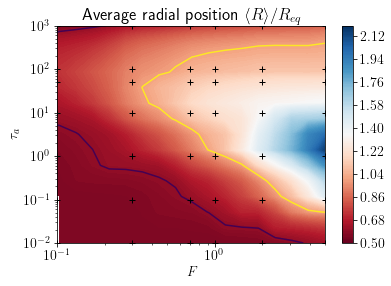

In [145]:
ax.clear()

Xi,Yi=np.meshgrid(np.geomspace(0.05,5,20),np.logspace(-2,3,15))
triang=tri.Triangulation(Fs,Tas)
interpZ=tri.LinearTriInterpolator(triang,np.around(np.array(Rmax), 3))
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.5,2.2,0.01),cmap='RdBu')
plt.colorbar()
plt.contour(Xi, Yi, Zi, levels=[0.6,1])
# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

plt.plot(Fs,Tas,'k+',)
plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
# plt.xlim(1,1e3)

plt.loglog()
plt.title('Average radial position $\\langle R\\rangle/R_{eq}$')
plt.xlim(0.1,5)
plt.ylim(0.01,1e3)
# plt.savefig(fpath+'plots/normAvgR_contour.png', dpi=300, bbox_inches='tight')